In [1]:
%load_ext autoreload
%autoreload 2


import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore') # we get a bunch of warnings for .loc errors that are about filters that are ok and not about setting values on slices...
# so, going to ignore everything so tha tthe notebooks are readable

pd.set_option('display.max_columns', None)


imputedDataset = pd.read_stata("/Users/burke.227/Documents/research/bpCog/microsim/microsim/data/fullyImputedDataset.dta")
imputedDataset.head()
noRecentUSInmigration = imputedDataset.loc[~imputedDataset.timeInUS.isin([1,2,3])]
earlyCrossSectionOfNonImmigrants = noRecentUSInmigration.loc[noRecentUSInmigration.year==2001]
# here we just need to throw out the very young people for comparisons
earlyCrossSectionOfNonImmigrants = earlyCrossSectionOfNonImmigrants.loc[earlyCrossSectionOfNonImmigrants.age > 18 + 2]

earlyCrossSectionOfNonImmigrants['strokeDeath'] = np.where(((earlyCrossSectionOfNonImmigrants.diedBy2015.values == 1) & (earlyCrossSectionOfNonImmigrants.ucod.values==2)), 1, 0)
earlyCrossSectionOfNonImmigrants['miDeath'] = np.where(((earlyCrossSectionOfNonImmigrants.diedBy2015.values == 1) & (earlyCrossSectionOfNonImmigrants.ucod.values==1)), 1, 0)
earlyCrossSectionOfNonImmigrants['cvDeath'] = np.where(((earlyCrossSectionOfNonImmigrants.strokeDeath.values == 1) | (earlyCrossSectionOfNonImmigrants.miDeath.values==1)), 1, 0)
earlyCrossSectionOfNonImmigrants['nonCVDeath'] = np.where(((earlyCrossSectionOfNonImmigrants.diedBy2015 ==1) & (earlyCrossSectionOfNonImmigrants.strokeDeath.values == 0) & (earlyCrossSectionOfNonImmigrants.miDeath.values==0)), 1, 0)
earlyCrossSectionOfNonImmigrants = earlyCrossSectionOfNonImmigrants.sample(n=50000, weights=earlyCrossSectionOfNonImmigrants.WTINT2YR, replace=True)

In [2]:
startYear = 1999
endYear = 2015
totalYears = endYear - startYear

In [3]:
import os
os.chdir("/Users/burke.227/Documents/research/bpCog/microsim/")
import logging
logging.basicConfig(level=logging.INFO)
from microsim.outcome import OutcomeType
from microsim.outcome_model_type import OutcomeModelType
from microsim.population import NHANESDirectSamplePopulation

In [4]:
pop = NHANESDirectSamplePopulation(n=250000, year=startYear) 

In [5]:
# uncommetn to run locally
popSurvival = pd.DataFrame({"index" : pop._people.index, "baseAge" : [person._age[0] for person in pop._people]} )
popSurvival['ageDecile'] = pd.qcut(popSurvival.baseAge, 10)
popSurvival['priorStroke'] = [person._stroke for person in pop._people]
# popSurvival['priorMI'] = [person._mi for person in pop._people]


#run the sim forward to sync up with NHANES population
for year in range(1,totalYears):
    pop.advance_vectorized(1)
    print(year)
    popSurvival['dead' + str(year)] = [person.is_dead() for person in pop._people]
    popSurvival['cvDeath' + str(year)] = [person.has_fatal_stroke() or person.has_fatal_mi() for person in pop._people]
    popSurvival['strokeDeath' + str(year)] = [person.has_fatal_stroke() for person in pop._people]
    popSurvival['miDeath' + str(year)] = [person.has_fatal_mi() for person in pop._people]
    popSurvival['nonCVDeath' + str(year)] = [person.is_dead() and (person.has_fatal_stroke() ==False) and (person.has_fatal_mi() == False) for person in pop._people]
    popSurvival['cvDeath' + str(year)] = [person.is_dead() and (person.has_fatal_stroke() ==True) or (person.has_fatal_mi() == True) for person in pop._people]


INFO:root:processing year: 0


1


INFO:root:processing year: 0


2


INFO:root:processing year: 0


3


INFO:root:processing year: 0


4


INFO:root:processing year: 0


5


INFO:root:processing year: 0


6


INFO:root:processing year: 0


7


INFO:root:processing year: 0


8


INFO:root:processing year: 0


9


INFO:root:processing year: 0


10


INFO:root:processing year: 0


11


INFO:root:processing year: 0


12


INFO:root:processing year: 0


13


INFO:root:processing year: 0


14


INFO:root:processing year: 0


15


In [6]:
import pickle
pickle.dump( popSurvival, open( "popSurvival.pickle", "wb" ) )
pickle.dump( pop, open( "pop.pickle", "wb" ) )

In [5]:
# # uncomment to load if run via external files

# os.chdir('/Users/burke/Documents/research/bpCog/nhanes/')
# popSurvival = pd.read_pickle('popSurvival.pickle')

# import pickle
# with open('pop.pickle', 'rb') as f:
#     pop = pickle.load(f)

In [6]:
len(pop._people)

250000

In [7]:
from microsim.outcome import OutcomeType

miIncidence = pop.calculate_mean_age_sex_standardized_incidence(OutcomeType.MI, 2000)
strokeIncidence = pop.calculate_mean_age_sex_standardized_incidence(OutcomeType.STROKE, 2000)

In [8]:
miIncidence

(237.88803546737, 9322)

In [9]:
strokeIncidence

(147.7855104157889, 6237)

In [10]:
import statsmodels.stats.proportion as prop


def getIncidence(incidence, popSize):
    overallIncidence = {'incidencePer100K' : incidence[0], 'numberEvents' : incidence[1], 
                              'denominator' : popSize, 'proportion' : incidence[1]/popSize,
                             'proportionLCI' : prop.proportion_confint(incidence[1], popSize)[0],
                              'proportionUCI' : prop.proportion_confint(incidence[1], popSize)[1]}
    overallIncidence['estimatedRelativeSE'] = (overallIncidence['proportion'] - overallIncidence['proportionLCI'])/1.96/overallIncidence['proportion']
    overallIncidence['estimatedIncidenceLCI'] = overallIncidence['incidencePer100K'] - 1.96 * (overallIncidence['estimatedRelativeSE'] * overallIncidence['incidencePer100K'])
    overallIncidence['estimatedIncidenceUCI'] = overallIncidence['incidencePer100K'] + 1.96 * (overallIncidence['estimatedRelativeSE'] * overallIncidence['incidencePer100K'])

    return overallIncidence

overallStrokeIncidence = getIncidence(strokeIncidence, len(pop._people))
overallMIIncidence = getIncidence(miIncidence, len(pop._people))

In [11]:
def printDict(dict):
    print("\n".join("{}\t{:.3f}".format(k, v) for k, v in dict.items()))

In [12]:
printDict(overallStrokeIncidence)

incidencePer100K	147.786
numberEvents	6237.000
denominator	250000.000
proportion	0.025
proportionLCI	0.024
proportionUCI	0.026
estimatedRelativeSE	0.013
estimatedIncidenceLCI	144.164
estimatedIncidenceUCI	151.407


In [13]:
printDict(overallMIIncidence)

incidencePer100K	237.888
numberEvents	9322.000
denominator	250000.000
proportion	0.037
proportionLCI	0.037
proportionUCI	0.038
estimatedRelativeSE	0.010
estimatedIncidenceLCI	233.150
estimatedIncidenceUCI	242.626


In [14]:
### Incideence by race
from microsim.race_ethnicity import NHANESRaceEthnicity
def isBlack(person):
    return person._raceEthnicity == NHANESRaceEthnicity.NON_HISPANIC_BLACK

def isBlackDF(person):
    return person.raceEthnicity == NHANESRaceEthnicity.NON_HISPANIC_BLACK

def isWhite(person):
    return person._raceEthnicity == NHANESRaceEthnicity.NON_HISPANIC_WHITE

def isWhiteDF(person):
    return person.raceEthnicity == NHANESRaceEthnicity.NON_HISPANIC_WHITE

In [15]:
whiteStrokeIncidence = pop.calculate_mean_age_sex_standardized_incidence(OutcomeType.STROKE, 2000, isWhite, isWhiteDF)
blackStrokeIncidence = pop.calculate_mean_age_sex_standardized_incidence(OutcomeType.STROKE, 2000, isBlack, isBlackDF)

overallWhiteStrokeIncidence = getIncidence(whiteStrokeIncidence, pop._people.map(isWhite).sum())
overallBlackStrokeIncidence = getIncidence(blackStrokeIncidence, pop._people.map(isBlack).sum())

In [16]:
printDict(overallWhiteStrokeIncidence)

incidencePer100K	117.676
numberEvents	3942.000
denominator	173477.000
proportion	0.023
proportionLCI	0.022
proportionUCI	0.023
estimatedRelativeSE	0.016
estimatedIncidenceLCI	114.045
estimatedIncidenceUCI	121.308


In [17]:
printDict(overallBlackStrokeIncidence)

incidencePer100K	240.820
numberEvents	890.000
denominator	27460.000
proportion	0.032
proportionLCI	0.030
proportionUCI	0.035
estimatedRelativeSE	0.033
estimatedIncidenceLCI	225.257
estimatedIncidenceUCI	256.383


In [18]:
whiteIncidenceMI = pop.calculate_mean_age_sex_standardized_incidence(OutcomeType.MI, 2000, isWhite, isWhiteDF)
blackIncidenceMI = pop.calculate_mean_age_sex_standardized_incidence(OutcomeType.MI, 2000, isBlack, isBlackDF)

overallWhiteIncidenceMI = getIncidence(whiteIncidenceMI, pop._people.map(isWhite).sum())
overallBlackIncidenceMI = getIncidence(blackIncidenceMI, pop._people.map(isBlack).sum())

In [19]:
printDict(overallWhiteIncidenceMI)

incidencePer100K	247.094
numberEvents	7314.000
denominator	173477.000
proportion	0.042
proportionLCI	0.041
proportionUCI	0.043
estimatedRelativeSE	0.011
estimatedIncidenceLCI	241.552
estimatedIncidenceUCI	252.636


In [20]:
printDict(overallBlackIncidenceMI)

incidencePer100K	217.784
numberEvents	809.000
denominator	27460.000
proportion	0.029
proportionLCI	0.027
proportionUCI	0.031
estimatedRelativeSE	0.035
estimatedIncidenceLCI	202.999
estimatedIncidenceUCI	232.568


In [21]:
# so...because of how we define primary vs. secondary events, this gets a little tricky
# they're all stored as outcomes on the person
# however, events prior to the sim are stored with an age of -1...
# we need to get able to define primary vs. secondary prevention to do the comparison...
# BUT we need to define events excluding the prior events (and they're stored in the same place)
# so, the slightly hacky work around is to store prior events as a flag on the person object (e.g. _selfReportMIPriorToSim)
# and then to DELETE for the purposes of this analysis the events from the outcomes list that have an age of -1

import copy

popCopy = copy.deepcopy(pop)
for person in pop._people:
    for outcomeType, outcomeTupleList in person._outcomes.items():
        if len(outcomeTupleList) > 0 and outcomeTupleList[0][0] < 0:
            outcomeTupleList.remove(outcomeTupleList[0])

### Incideence by primvary vs. seconeary status...
def hasCVEvent(person):
    return person._selfReportStrokePriorToSim or person._selfReportMIPriorToSim

def hasCVEventDF(person):
    return person.miPriorToSim or person.strokePriorToSim

secondaryMIIncidence = popCopy.calculate_mean_age_sex_standardized_incidence(OutcomeType.MI, 2000, hasCVEvent,hasCVEventDF )
print(f"Secondary MI Incidence: {secondaryMIIncidence[0]} \nevent count: {secondaryMIIncidence[1]}")

### Incideence by primvary vs. seconeary status...
def noCVEvent(person):
    return (not person._selfReportStrokePriorToSim) and (not person._selfReportMIPriorToSim)

def noCVEventDF(person):
    return (not person.miPriorToSim) and (not person.strokePriorToSim)

primaryMiIncidence = popCopy.calculate_mean_age_sex_standardized_incidence(OutcomeType.MI, 2000, noCVEvent, noCVEventDF)
secondaryMiIncidence = popCopy.calculate_mean_age_sex_standardized_incidence(OutcomeType.MI, 2000, hasCVEvent,hasCVEventDF)
secondaryStrokeIncidence = popCopy.calculate_mean_age_sex_standardized_incidence(OutcomeType.STROKE, 2000, hasCVEvent,hasCVEventDF)
primaryStrokeIncidence = popCopy.calculate_mean_age_sex_standardized_incidence(OutcomeType.STROKE, 2000, noCVEvent,noCVEventDF)

overallPrimaryStroke = getIncidence(primaryStrokeIncidence, pop._people.map(noCVEvent).sum())
overallSecondaryStroke = getIncidence(secondaryStrokeIncidence, pop._people.map(hasCVEvent).sum())
overallPrimaryMI = getIncidence(primaryMiIncidence, pop._people.map(noCVEvent).sum())
overallSecondaryMI = getIncidence(secondaryMiIncidence, pop._people.map(hasCVEvent).sum())

Secondary MI Incidence: 273.2345758226326 
event count: 980.0


In [22]:
overallPrimaryStroke

{'incidencePer100K': 148.23766157844614,
 'numberEvents': 5504,
 'denominator': 237519,
 'proportion': 0.023172883011464345,
 'proportionLCI': 0.022567823905789253,
 'proportionUCI': 0.023777942117139437,
 'estimatedRelativeSE': 0.01332176169843473,
 'estimatedIncidenceLCI': 144.36707944597484,
 'estimatedIncidenceUCI': 152.10824371091744}

In [23]:
overallSecondaryStroke

{'incidencePer100K': 166.85704907273532,
 'numberEvents': 733.0,
 'denominator': 12481,
 'proportion': 0.058729268488101914,
 'proportionLCI': 0.05460442026980218,
 'proportionUCI': 0.06285411670640165,
 'estimatedRelativeSE': 0.03583416669863781,
 'estimatedIncidenceLCI': 155.13784978255757,
 'estimatedIncidenceUCI': 178.57624836291308}

In [24]:
overallPrimaryMI

{'incidencePer100K': 236.33377900399518,
 'numberEvents': 8342,
 'denominator': 237519,
 'proportion': 0.03512140081425065,
 'proportionLCI': 0.034381077946237196,
 'proportionUCI': 0.035861723682264104,
 'estimatedRelativeSE': 0.010754575279730774,
 'estimatedIncidenceLCI': 231.3521069458094,
 'estimatedIncidenceUCI': 241.31545106218095}

In [25]:
overallSecondaryMI

{'incidencePer100K': 273.2345758226326,
 'numberEvents': 980.0,
 'denominator': 12481,
 'proportion': 0.07851934941110487,
 'proportionLCI': 0.0738002964019133,
 'proportionUCI': 0.08323840242029645,
 'estimatedRelativeSE': 0.030663525930716418,
 'estimatedIncidenceLCI': 256.8130382408577,
 'estimatedIncidenceUCI': 289.65611340440756}

In [26]:
df = pop.get_people_current_state_as_dataframe(parallel=False)
df['cvEvent'] = 0
df.loc[((df.strokePriorToSim ==1) | (df.miPriorToSim==1)), 'cvEvent'] = 1
denominator = df.cvEvent.value_counts()
print(f"Absolute event rate in secondary prevention: {secondaryStrokeIncidence[1]/denominator[1]:.2f}, absolute event rate in primary prevention: {primaryStrokeIncidence[1]/denominator[0]:.2f}" )

Absolute event rate in secondary prevention: 0.06, absolute event rate in primary prevention: 0.02


In [27]:
# quick look at the characterictis of ghe primary vs. secondary pops
df.groupby('cvEvent')[['age', 'sbp', 'dbp', 'a1c', 'ldl', 'bmi', 'dead']].mean()

,age,sbp,dbp,a1c,ldl,bmi,dead
cvEvent,,,,,,,
0,57.021510,124.567679,77.966908,5.471104,120.692685,28.362494,0.129893
1,74.453009,133.569244,71.494662,6.164832,116.748710,29.148432,0.537297


#### Looking at the primary vs. secondary prevention data...the absolute rates are much higher in secondary prevention (as shown above), but the age-standardized incidence rates aren't very differnet (for stroke) because of the MUCH higher age at the timeof event. I don't thin this is a big problem 


### MI incidence should be a around 200/100k (assuming that yeh underestiamtes because its in kaiser and primary prevention only)
<ul><li>aroudn 175 in PhD, K. R., MD, A. S. G., MPH, T. K. L., RPh, D. M. B. P., PhD, A. E. C.-B., MD, S. P. F., et al. (2017). Trends in Incidence of Hospitalized Acute Myocardial Infarction in the Cardiovascular Research Network (CVRN). The American Journal of Medicine, 130(3), 317–327. http://doi.org/10.1016/j.amjmed.2016.09.014</li>
<li>around 200 in Yeh, R. W., Sidney, S., Chandra, M., Sorel, M., Selby, J. V., & Go, A. S. (2010). Population trends in the incidence and outcomes of acute myocardial infarction. The New England Journal of Medicine, 362(23), 2155–2165. http://doi.org/10.1056/NEJMoa0908610</li></ul>

### Stroke incidence is harder to pin down — ranges from 130-300+
<ul>
<li>aroudn 130 in Morgenstern, L. B., Smith, M. A., Sánchez, B. N., Brown, D. L., Zahuranec, D. B., Garcia, N., et al. (2013). Persistent ischemic stroke disparities despite declining incidence in Mexican Americans. Annals of Neurology, 74(6), 778–785. http://doi.org/10.1002/ana.23972</li>
<li>around 200 in Kleindorfer, D. O., Khoury, J., Moomaw, C. J., Alwell, K., Woo, D., Flaherty, M. L., et al. (2010). Stroke Incidence Is Decreasing in Whites But Not in Blacks: A Population-Based Estimate of Temporal Trends in Stroke Incidence From the Greater Cincinnati/Northern Kentucky Stroke Study * Supplemental Material, 41(7), 1326–1331. http://doi.org/10.1161/STROKEAHA.109.575043</li>
<li>appears to be much higher in REGARDS< (460) and then summarize rates from 100-480! Howard, V. J., Kleindorfer, D. O., Judd, S. E., Mcclure, L. A., Safford, M. M., Rhodes, J. D., et al. (2011). Disparities in stroke incidence contributing to disparities in stroke mortality. Annals of Neurology, 69(4), 619–627. http://doi.org/10.1002/ana.22385</li>
<li>Hospitalizaiton rate is around 200/100k: Ramirez, L., Kim Tenser, M. A., Sanossian, N., Cen, S., Wen, G., He, S., et al. (2016). Trends in Acute Ischemic Stroke Hospitalizations in the United States. Journal of the American Heart Association, 5(5), 1–8. http://doi.org/10.1161/JAHA.116.003233</li></ul>

### We generally reproduce black-white disparities.
<ul>
    <li>From the Kleindorfer paper above, black incidence is about 1.8x white incience. In the Howard paper above, it summarizes differences from 1.6-2.8. Our estimate comes out around 2.1 - so in the middle of that range.</li>
    <li>Interestingly, I did not know that there is no major disparity in MI incidence by race. Yet, that appears to be the case in Kaiser, at least. (Chi, G. C., Kanter, M. H., Li, B. H., Qian, L., Reading, S. R., Harrison, T. N., et al. (2020). Trends in Acute Myocardial Infarction by Race and Ethnicity. Journal of the American Heart Association, 9(5), e013542. http://doi.org/10.1161/JAHA.119.013542)
    </li>
    <li>Our simulation relatively comes up wiht a 10-15% higher incidence of MI in whites than blacks which is generally concordant with the Kaiser data
</ul>    


### Numerically, in the whole population there should be slightly more MIs than strokes when including primary + secondary events
https://www.heart.org/-/media/data-import/downloadables/heart-disease-and-stroke-statistics-2018---at-a-glance-ucm_498848.pdf

— it is harder to talk about primary vs. secondary incidence, because secondary events occur in a much older population and rarely is incidence reported by primary and secondary status. so, its hard to determine if the simulation is producing valid results regarding primary vs. secondary effects using incidence

### age standardized all cause mortality for the whole population...
- https://www.cdc.gov/nchs/data/nvsr/nvsr67/nvsr67_05.pdf
- in 2016, age standardized death rate is 728.8 deaths per 100,000, crude death rate is 849.3 per 100,000 population.




In [28]:
print(f"Overall mortality: {pop.calculate_mean_age_sex_standardized_mortality(2000)}")

Overall mortality: 788.5046698585622


In [29]:
lifeTable = pd.read_excel('/Users/burke.227/Documents/research/bpCog/nhanes/probSurvLifeTables_ss2019.xlsx')
lifeTable['meanSurvProb'] = (lifeTable.maleProbSurv + lifeTable.femaleProbSurv)/2

In [30]:
# a bunch of reporting code that shoudl probably get pushed to person...
def prob_mortality_by_age(pop):
    denominatorForAgeMale = {i : 0 for i in range(18, 200)}
    numeratorForAgeMale = {i : 0 for i in range(18, 200)}
    denominatorForAgeFemale = {i : 0 for i in range(18, 200)}
    numeratorForAgeFemale = {i : 0 for i in range(18, 200)}

    for i, person in pop._people.iteritems():
        if int(person._gender) ==2:
            process_person(person, pop, denominatorForAgeFemale, numeratorForAgeFemale)
        else:
            process_person(person, pop, denominatorForAgeMale, numeratorForAgeMale)

    denominatorForAgeMale = {i : x for i, x in denominatorForAgeMale.items() if x > 0}
    denominatorForAgeFemale = {i : x for i, x in denominatorForAgeFemale.items() if x > 0}
    male = {age : numeratorForAgeMale[age] / rate for age, rate in denominatorForAgeMale.items()}
    female =  {age : numeratorForAgeFemale[age] / rate for age, rate in denominatorForAgeFemale.items()}
    
    maleMortalityDF = pd.DataFrame({'age' : male.keys(), 'mortality': male.values()})
    femaleMortalityDF = pd.DataFrame({'age' : female.keys(), 'mortality': female.values()})

    return maleMortalityDF,femaleMortalityDF

def get_pop_mortality_deviation(pop, lifeTable):
    mortByAgeMale, mortByAgeFemale = prob_mortality_by_age(pop)
    return compare_to_life_table(mortByAgeMale, mortByAgeFemale, lifeTable)

def compare_to_life_table(male, female, lifeTable):
    maleDiff = male-lifeTable.iloc[:,:2].rename(columns={'Age' : 'age', 'maleProbSurv' : 'mortality'})
    femaleDiff = female-lifeTable.iloc[:, np.r_[0, 2]].rename(columns={'Age' : 'age', 'femaleProbSurv' : 'mortality'})
    maleDiff['squareDiffs'] = maleDiff['mortality'] **2
    femaleDiff['squareDiffs'] = femaleDiff['mortality'] **2
    totalDiff = maleDiff + femaleDiff
    return totalDiff['squareDiffs'].sum(), totalDiff['squareDiffs']

def process_person(person, pop, denominator, numerator):
    for i, personAge in enumerate(person._age):
        denominator[int(personAge)]= denominator[int(personAge)]+1
        if i==pop._currentWave:
            break

        diedAtAge = not person._alive[i+1]
        if diedAtAge:
            numerator[int(personAge)]= numerator[int(personAge)]+1
            break
            
def plot_pop(pop, label="", cap=200):
    male, female = prob_mortality_by_age(pop)
    combined = male
    combined.rename(columns={'mortality' : 'maleMortality'}, inplace=True)
    combined['femaleMortality'] = female['mortality']

    combined['combinedMortality'] = (combined['maleMortality'] + combined['femaleMortality'] ) /2
    combinedCap = combined.loc[combined.age < cap]
    plt.plot(combinedCap.age, combinedCap.combinedMortality, label=label)
    return combinedCap
import matplotlib.pyplot as plt
#plt.plot(lifeTable.Age, lifeTable.meanSurvProb)

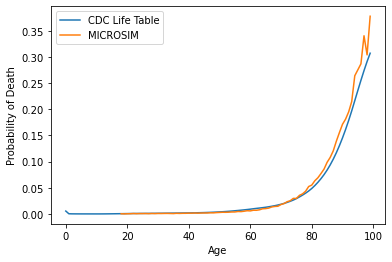

In [31]:
lifeTableCap100 = lifeTable.loc[lifeTable.Age < 100 ]
plt.plot(lifeTableCap100.Age, lifeTableCap100.meanSurvProb, label='CDC Life Table')
plot_pop(pop, "MICROSIM", 100)

plt.ylabel("Probability of Death")
plt.xlabel("Age")

plt.legend(loc='upper left')
plt.savefig('ProbabilitlyOfDeathByAge.eps')

### Upshot — MI incidence is reasonable, perhaps a little high, Stroke incidence is reasonable, probably a little low relative to MI hard to judge given variability.
— Wouldn't make changes at this point, instead will wait until we have better partitioning models and better event moretality models from the combined cohorts

### Overall mortality incidence is slightly overestimated by comparison, but has been recalibrated to lifetables such that mortality at a given age is very similar to CDC estimates

### Rest of the notebook explores disconnects in how mortality is measured by type. 

Our conclusion is that there are major disconnects between death certificates and the epidemiology for CAD/MI and that we generally think tha the epidemiooogy is more likly to be relevant to the clincial decisios that we're studying.

In [40]:
# on UCOD 1 = MI, 2=stroke, 3 = other cause of death
earlyCrossSectionOfNonImmigrants.ucod.value_counts(normalize=True, sort=False)

0    0.88204
1    0.03922
2    0.00648
3    0.07226
Name: ucod, dtype: float64

In [11]:
print("NHANES Overall mortality %0.3f" % earlyCrossSectionOfNonImmigrants.diedBy2015.mean())
print("Sim aoverall mortality %0.3f" % popSurvival.dead14.mean())

NHANES Overall mortality 0.119
Sim aoverall mortality 0.130


In [12]:
print("NHANES CV mortality %0.3f" % earlyCrossSectionOfNonImmigrants.cvDeath.mean())
print("Sim CV mortality %0.3f" % popSurvival.cvDeath14.mean())

NHANES CV mortality 0.044
Sim CV mortality 0.010


In [13]:
print("NHANES non-CV mortality %0.3f" % earlyCrossSectionOfNonImmigrants.nonCVDeath.mean())
print("Sim non-CV mortality %0.3f" % popSurvival.nonCVDeath14.mean())

NHANES non-CV mortality 0.074
Sim non-CV mortality 0.120


In [14]:
print("NHANES Heart Diasease mortality %0.3f" % earlyCrossSectionOfNonImmigrants.miDeath.mean())
print("Sim MI mortality %0.3f" % popSurvival.miDeath14.mean())

NHANES Heart Diasease mortality 0.037
Sim MI mortality 0.005


In [15]:
print("NHANES Stroke mortality %0.3f" % earlyCrossSectionOfNonImmigrants.strokeDeath.mean())
print("Sim stroke mortality %0.3f" % popSurvival.strokeDeath14.mean())

NHANES Stroke mortality 0.007
Sim stroke mortality 0.005


### CV Mortality is the primary problem
<p>CV mortality is <b>much</b> highger in NHANES than in the simulation (4.6% vs. 0.8%), whereas non-CV mortality is pretty close (which makes sense since we derived the non-CV mortality omdel from NHANES). This is mostly due to massive (10-fold) underestimationof raw mortality due to MI (3.9% vs. 0.4%)
    
### Next steps
<ol>
    <li><b> Rerun non-CV mortality model in NHANES with updated data</b> (Done)</li>
    <li> <b>Run mortality incidence code on NHANES — are we wildly over in NHANES compared to CDC estimates?</b> (Done) </li>
    <li> Might have to run incidnce code on death cerrts — can we reproduce the CDC etimates (i.e is there a code problem in the incidence calc?) (Incidenece calcs have been checked quite a bit...I trust them now)</li>
    <li> <b>Document the epi logic problem that is in the emali to Jeremy </b> (Done)</li>
    <li> <b>Play with the assumptions to see how far we could move things</b> (Done)</li>
    <li> <b>Check incidende in subgroups by race/ethnicity and gender and for primary/secondary prevention</b> (Done)</li>
    <li> <b>Is the story here about primary vs. secondary prevention? If secondaray events are much more common given primary events and they have much higher mortality, then this could close part of the gap... (Jeremy's email)</b> (Done)</li>
</ol>

### #2 Run mortality incidence code on NHANES — are we wildly over in NHANES compared to CDC estimates?



In [ ]:
earlyCrossSectionOfNonImmigrants['yearInSim'] = earlyCrossSectionOfNonImmigrants.monthsToDeath/12

# set years in sim to years until death amongst peopel that die.
ageStandard = pop.build_age_standard(2016)

for index, row in earlyCrossSectionOfNonImmigrants.iterrows():
    nhanesFemale = row['gender'] - 1
    if (row['ucod'] != 0):
        ageStandard.loc[((ageStandard['lowerAgeBound'] <= row['age']) & (ageStandard['upperAgeBound'] >= row['age']) & (ageStandard['female'] == nhanesFemale)),
                        'outcomeCount'] += 1
    ageStandard.loc[((ageStandard['lowerAgeBound'] <= row['age']) &
                     (ageStandard['upperAgeBound'] >= row['age']) &
                     (ageStandard['female'] == nhanesFemale)),
                    'simPersonYears'] += row['yearInSim']
ageStandard = pop.tabulate_age_specific_rates(ageStandard)
print (ageStandard['ageSpecificContribution'].sum())

### So, estiamted morality is higher in NHANES that in our overall population and consideralby higher than in daeth certificate data

My guess is that this is a calculation problem...NHANES and our sim are both coming up in the same neighborhood and its much higher than CDC...the next xtep would be to run teh same calc on teh CDC death certs, but that would be a time consuming step

### #3. Broadly, we have a problem with the epidemiology here.

1. <b>Age standardizd incidence rates of MI (mostly primary prevention?) are around 200/100k. (above)</b>
2. <b >Case fatality is around 10%</b> (same refs as above)
3. <b>THat implies that mortlaity should be around 20k/100k.</b> (And is very close to what the sim is doing)
4. <b>However, death certificate assessed morrality is also around 200/100k</b> (Sidney, S., Quesenberry, C. P., Jr, Jaffe, M. G., Sorel, M., Nguyen-Huynh, M. N., Kushi, L. H., et al. (2016). Recent Trends in Cardiovascular Mortality in the United States and Public Health Goals. JAMA Cardiology, 1(5), 594–6. http://doi.org/10.1001/jamacardio.2016.1326)


So...we have a 10-fold gap in mortality on our hands. Theories:
<ol>
<li><b>Part of this is the differnece between heart diasese and MI mortality.</b> Straight MI dx on death certs make the problem half as big 100k/200k (Underlying Cause of death 1999-2017.xls spreadsheet from CDC wonder(although, its not obvious that MI isn't the primary cause of mortality in a lot of the other "heart disease" dx, such as CHF...)</li>

<li><b>Death certificates over-report cardiovacular mortality</b>
<ul><li>Our paper on stroke AMCOD vs. UCOD compared to MI (which, agian likely understates the degree of overestimation  because many MIs will end up with heart disease deaths...)</li>
<li>Jack's paper linking death certs to admin data suggesting that correlaton is lousy and that "diseases of the heart" are plausibly over estriamted</li></ul></li>

<li><b> Primary vs. Secondary Preventino </b> Our current modles dont' increase rates for secondary events or case fatality...how much would we have to increase to get close to death certs? That seems like an assumption we can play with pretty easily</li>
<li><b> better mortality model - right now, old people aren't dying off enough with CV events</b></li>
</ol>

### 4. Play with the assumptions to see how far we could move things

First, let's double the risk for secondary prevention and double the case fatality rate in secondary prevention



In [ ]:
caseFatalityMultiplier = [1,2,3,4,5]
secondaryIncidenceMultiplier=[1,2,3,4,5,6,7]
results = []

for fatalityMult in caseFatalityMultiplier:
    for incidenceMult in secondaryIncidenceMultiplier:
        print("fatality {:d}, incidence {:d}".format(fatalityMult, incidenceMult))
        popSens = NHANESDirectSamplePopulation(n=3000, year=2001) 

        popSens._outcome_model_repository.secondary_mi_case_fatality = fatalityMult * popSens._outcome_model_repository.mi_case_fatality
        popSens._outcome_model_repository.secondary_stroke_case_fatality = fatalityMult * popSens._outcome_model_repository.stroke_case_fatality
        popSens._outcome_model_repository.secondary_prevention_multiplier = incidenceMult

        popSensDF = pd.DataFrame({"index" : popSens._people.index, "baseAge" : [person._age[0] for person in popSens._people]} )
        popSensDF['ageDecile'] = pd.qcut(popSensDF.baseAge, 10)
        for year in range(1,15):
            popSens.advance(1)
            popSensDF['dead' + str(year)] = [person.is_dead() for person in popSens._people]
            popSensDF['cvDeath' + str(year)] = [person.has_fatal_stroke() or person.has_fatal_mi() for person in popSens._people]
            popSensDF['strokeDeath' + str(year)] = [person.has_fatal_stroke() for person in popSens._people]
            popSensDF['miDeath' + str(year)] = [person.has_fatal_mi() for person in popSens._people]
            popSensDF['nonCVDeath' + str(year)] = [person.is_dead() and (person.has_fatal_stroke() ==False) and (person.has_fatal_mi() == False) for person in popSens._people]
            popSensDF['cvDeath' + str(year)] = [person.is_dead() and (person.has_fatal_stroke() ==True) or (person.has_fatal_mi() == True) for person in popSens._people]

        results.append((fatalityMult, 
                        incidenceMult, 
                        popSensDF.dead14.mean(), 
                        popSensDF.cvDeath14.mean(),
                        popSensDF.nonCVDeath14.mean(),
                        popSensDF.miDeath14.mean(),
                        popSensDF.strokeDeath14.mean()))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

cvMort= np.array([result[3] for result in results]).reshape(5,7)
plt.contourf(cvMort, levels=[0.0, 0.01, 0.015, 0.02, 0.025, 0.03,0.035, 0.04])
plt.xticks(np.arange(7), np.arange(1,8))
plt.yticks(np.arange(5), np.arange(1,6))
plt.xlabel('Secondary Risk Multiplier (ASCVD * x = risk in secondary prevention)')
plt.ylabel('Secondary Case Fatality Multiplier\n (Primary case fatality * y = \ncase fatality in secondary prevention)')
plt.colorbar()

#### So...to get a CV mortality rate that approximates what is measured in NHANES, we need to multiply the secondary prevention risk by 7! and the secondary case fatality risk by 5!

In [ ]:
earlyCrossSectionOfNonImmigrants['ageDecile'] = pd.qcut(earlyCrossSectionOfNonImmigrants.age, 10)

mortalityByDecileNHANES = earlyCrossSectionOfNonImmigrants[['diedBy2015','ageDecile']].groupby(earlyCrossSectionOfNonImmigrants.ageDecile).mean()
mortalityByDecileSim = popSurvival[['dead10', 'ageDecile']].groupby(popSurvival.ageDecile).mean()

simBar =plt.bar(mortalityByDecileSim.index.codes+0.5, mortalityByDecileSim.dead10, width=0.5, label="sim")
nhanesBar = plt.bar(mortalityByDecileNHANES.index.codes, mortalityByDecileNHANES.diedBy2015, width=0.5, label="nhanes")
plt.legend()


In [ ]:
strokeMortalityByDecileNHANES = earlyCrossSectionOfNonImmigrants[['strokeDeath','ageDecile']].groupby(earlyCrossSectionOfNonImmigrants.ageDecile).mean()
mortalityByDecileSim = popSurvival[['strokeDeath10', 'ageDecile']].groupby(popSurvival.ageDecile).mean()

simBar =plt.bar(mortalityByDecileSim.index.codes+0.5, mortalityByDecileSim.strokeDeath10, width=0.5, label="sim")
nhanesBar = plt.bar(mortalityByDecileNHANES.index.codes, strokeMortalityByDecileNHANES.strokeDeath, width=0.5, label="nhanes")
plt.legend()

In [ ]:
miMortalityByDecileNHANES = earlyCrossSectionOfNonImmigrants[['miDeath','ageDecile']].groupby('ageDecile').mean()
miMortalityByDecileSim = popSurvival[['miDeath10', 'ageDecile']].groupby(popSurvival.ageDecile).mean()

simBar =plt.bar(miMortalityByDecileSim.index.codes+0.5, miMortalityByDecileSim.miDeath10, width=0.5, label="sim")
nhanesBar = plt.bar(miMortalityByDecileNHANES.index.codes, miMortalityByDecileNHANES.miDeath, width=0.5, label="nhanes")
plt.legend()

In [ ]:
cvMortalityByDecileNHANES = earlyCrossSectionOfNonImmigrants[['cvDeath','ageDecile']].groupby(earlyCrossSectionOfNonImmigrants.ageDecile).mean()
cvMortalityByDecileSim = popSurvival[['cvDeath10', 'ageDecile']].groupby(popSurvival.ageDecile).mean()

simBar =plt.bar(cvMortalityByDecileSim.index.codes+0.5, cvMortalityByDecileSim.cvDeath10, width=0.5, label="sim")
nhanesBar = plt.bar(cvMortalityByDecileNHANES.index.codes, cvMortalityByDecileNHANES.cvDeath, width=0.5, label="nhanes")
plt.legend()

In [ ]:
nonCVMortalityByDecileNHANES = earlyCrossSectionOfNonImmigrants[['nonCVDeath','ageDecile']].groupby(earlyCrossSectionOfNonImmigrants.ageDecile).mean()
nonCVMortalityByDecileSim = popSurvival[['nonCVDeath10', 'ageDecile']].groupby(popSurvival.ageDecile).mean()

nonCVsimBar =plt.bar(nonCVMortalityByDecileSim.index.codes+0.5, nonCVMortalityByDecileSim.nonCVDeath10, width=0.5, label="sim non cv")
cvSimBar =plt.bar(cvMortalityByDecileSim.index.codes+0.5, cvMortalityByDecileSim.cvDeath10, width=0.5, label="sim cv", bottom=nonCVMortalityByDecileSim.nonCVDeath10)

nonCVnhanesBar = plt.bar(nonCVMortalityByDecileNHANES.index.codes, nonCVMortalityByDecileNHANES.nonCVDeath, width=0.5, label="nhanes nonCV")
cvnhanesBar = plt.bar(cvMortalityByDecileNHANES.index.codes, cvMortalityByDecileNHANES.cvDeath, width=0.5, bottom=nonCVMortalityByDecileNHANES.nonCVDeath, label="nhanes CV")
plt.legend()

### So, we have slight under prediction of mortality in the simulation. Is that because of the code or the data?

To test — we will rerun the simulation on the direct NHANES data that we use in the calibration...

In [ ]:
from mcm.gender import NHANESGender
from mcm.person import Person
from mcm.outcome import Outcome
from mcm.race_ethnicity import NHANESRaceEthnicity
from mcm.smoking_status import SmokingStatus
from mcm.cohort_risk_model_repository import CohortRiskModelRepository
from mcm.outcome_model_repository import OutcomeModelRepository

In [ ]:
import os 

def calcMortalityRunningFullModel(x):
        temp =  Person(
            age=x.age,
            gender=NHANESGender(int(x.gender)),
            raceEthnicity=NHANESRaceEthnicity(int(x.raceEthnicity)),
            sbp=x.meanSBP,
            dbp=x.meanDBP,
            a1c=x.a1c,
            hdl=x.hdl,
            ldl=x.ldl,
            trig=x.trig,
            totChol=x.tot_chol,
            bmi=x.bmi,
            smokingStatus=SmokingStatus(int(x.smokingStatus)),
            dfIndex=x.index,
            diedBy2011=x.diedBy2011)
        
        for year in range(1,11):
            if not temp.is_dead():
                temp.advance_year(riskModel, cohortModel)
        return temp.is_dead()

earlyCrossSectionOfNonImmigrants['estMortalityFromModel'] = earlyCrossSectionOfNonImmigrants.apply(calcMortalityRunningFullModel, axis=1)

In [ ]:
earlyCrossSectionOfNonImmigrants['ageDecile'] = pd.qcut(earlyCrossSectionOfNonImmigrants.age, 10)
output = earlyCrossSectionOfNonImmigrants.groupby('ageDecile')[['diedBy2011', 'estMortalityFromModel']].mean()
print(output)
plt.bar(output.index.codes+1, output.diedBy2011, width=0.5, label="actualDeath")
plt.bar(output.index.codes+1.5, output.estMortalityFromModel, width=0.5, label="model")

plt.legend()

### Ok...this looks quite good...on the same data, the under-prediction problem looks very modest

In [ ]:
earlyCrossSectionOfNonImmigrants.to_stata("/Users/burke/Documents/research/bpCog/nhanes/earlyCrossSectionOfNonImmigrants.dta")
earlyCrossSectionOfNonImmigrants.ageDecile.value_counts().sort_index()

In [ ]:
earlyCrossSectionOfNonImmigrants[['diedBy2011', 'estMortalityFromCox', 'estMortalityFromModel']].mean()

In [ ]:
# well...this is not easy to explain.
# for the most part the code-bsaed calculation looks similar, gut it under predicts mortaltiy substantially in the highest age decile
# this is a bit strange...but, not impossible. if you look at the within population validation, it seems that we under-predicted in the oldest cohort for our basee model as well
# i wonder if having a longer follow-up (by constraining to the early oohort might cause that problem...that should be straight-forward to check)

# the code based model is over-estmiaging mortalty thorughout.
# this is going to be harder to figure otu...
# possibilities: 1. the times aren't right...and the cohort model is getting exposed to more time than the comparators
# the time aggregation isn't right...the one year probabilities are summing to something greater than the whole

In [ ]:
earlyCrossSectionOfNonImmigrants.ucod.value_counts()

In [ ]:
# next steps — 1. see if we under-preditx mortality badly in the NHANES popualtion if we look at only the people that are enrolled early (and thus have long follow-up)